# File and libraries

In [1]:
import pandas as pd
import numpy as np


filepath=r'data/df_merch_7_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

file_tag = "df_merch_final"

# DSLabs functions

In [2]:
%run "scripts/dslabs_functions.py"


# Data functions

In [3]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [4]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)

    data=data.sample(frac=0.05, replace=False)
    test=test.sample(frac=0.05, replace=False)
    train=train.sample(frac=0.05, replace=False)
    
    
else:
    data=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # larger sample 10%
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)


 
target='returning_user'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74334 entries, 0 to 74333
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   device_category                  74334 non-null  float64
 1   device_mobile_model_name         74334 non-null  float64
 2   device_operating_system          74334 non-null  float64
 3   device_operating_system_version  74334 non-null  float64
 4   device_language                  74334 non-null  float64
 5   device_web_info_browser          74334 non-null  float64
 6   device_web_info_browser_version  74334 non-null  float64
 7   geo_region                       74334 non-null  float64
 8   geo_city                         74334 non-null  float64
 9   traffic_source_medium            74334 non-null  float64
 10  traffic_source_source            74334 non-null  float64
 11  engagement_time_msec             74334 non-null  float64
 12  month                  

# Distribution Check

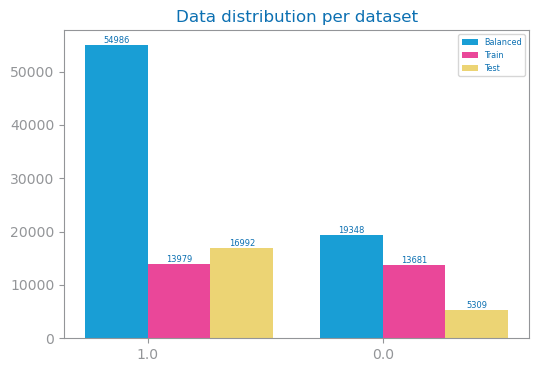

In [5]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Balanced": [
        len(data[data[target] == 0]),  # Assuming 0 is the negative class
        len(data[data[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

## Evaluate for best model - RForests

Train#=27660 Test#=22301
Labels=[0.0, 1.0]
RF best for 100 trees (d=7 and f=0.3)


<Figure size 640x480 with 0 Axes>

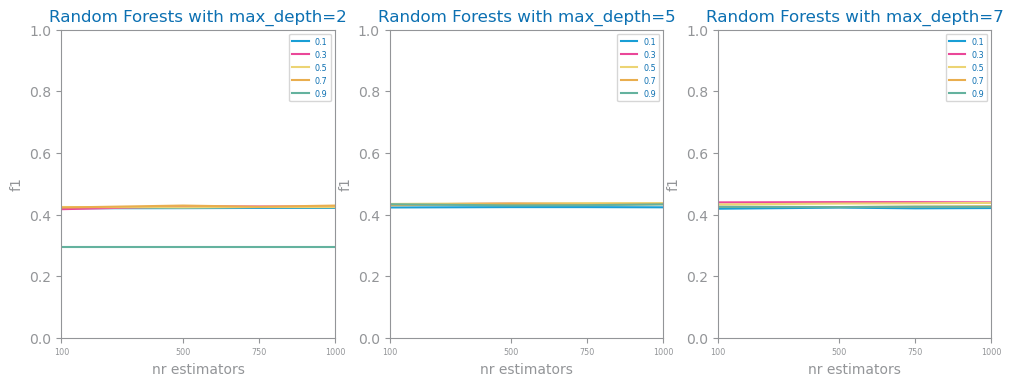

In [6]:
if evaluate==True:

    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')

    figure()

    eval_metric = 'f1'

    best_model, params = random_forests_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
    )
    
    savefig(f'images/{file_tag}_rf_{eval_metric}_study.png')
    show()
    

# Best Model Performance

<Figure size 640x480 with 0 Axes>

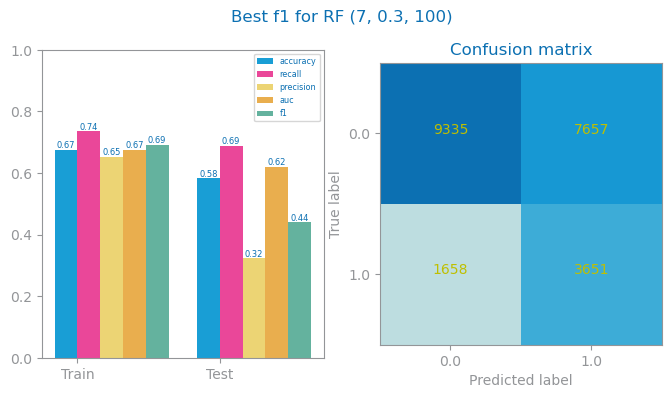

In [7]:
if evaluate == True:
    prd_trn: array = best_model.predict(trnX)
    prd_tst: array = best_model.predict(tstX)
    figure()
    plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
    savefig(f'images/{file_tag}_rf_{params["name"]}_best_{params["metric"]}_eval.png')
    show()

# Variables importance


1. traffic_source_medium (0.2909030000065604)
2. traffic_source_source (0.12901271558688154)
3. page_path_level_3 (0.09036147507442664)
4. session_engaged (0.03513751399558274)
5. device_language (0.03268321793560684)
6. geo_city (0.03171819485579028)
7. day_of_year (0.03064601870436247)
8. day_sin (0.025234417401754836)
9. hour_minute_fraction_cos (0.025015142144132918)
10. geo_region (0.024396904111326174)
11. hour_minute_fraction_sin (0.022164171330743002)
12. engagement_time_msec (0.02091441030252762)
13. page_path_level_1 (0.019772727408770653)
14. day_cos (0.01931413628874086)
15. page_path_level_2 (0.019138759641327042)
16. device_mobile_model_name (0.017231649094223856)
17. week_number (0.015898315956374306)
18. domain (0.013768815338382853)
19. local_hour_sin (0.013454836655052189)
20. device_operating_system_version (0.012859935332801432)
21. is_weekend (0.01074686618162445)
22. local_hour_cos (0.010546412035887123)
23. day_of_week_nr_cos (0.009981104666626921)
24. device_web

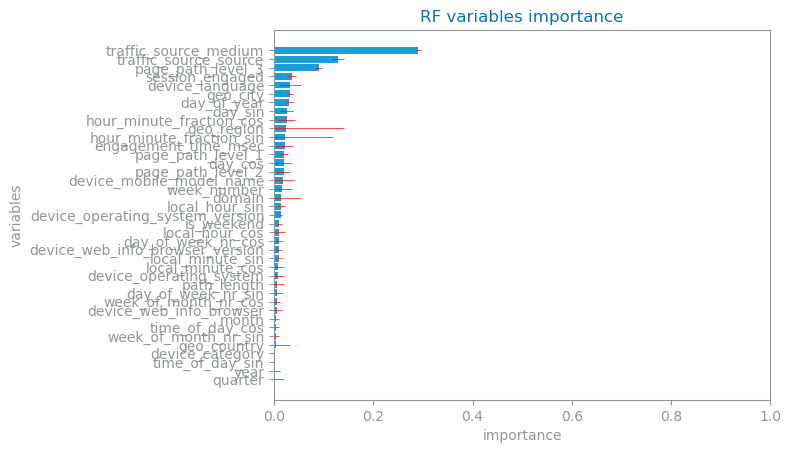

In [8]:
if evaluate==True:
    from numpy import std, argsort
    from dslabs_functions import plot_horizontal_bar_chart

    stdevs: list[float] = list(
        std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
    )
    importances = best_model.feature_importances_
    indices: list[int] = argsort(importances)[::-1]
    elems: list[str] = []
    imp_values: list[float] = []
    for f in range(len(vars)):
        elems += [vars[indices[f]]]
        imp_values.append(importances[indices[f]])
        print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

    figure()
    plot_horizontal_bar_chart(
        elems,
        imp_values,
        error=stdevs,
        title="RF variables importance",
        xlabel="importance",
        ylabel="variables",
        percentage=True,
    )
    savefig(f"images/{file_tag}_rf_{eval_metric}_vars_ranking.png")

# Overfitting

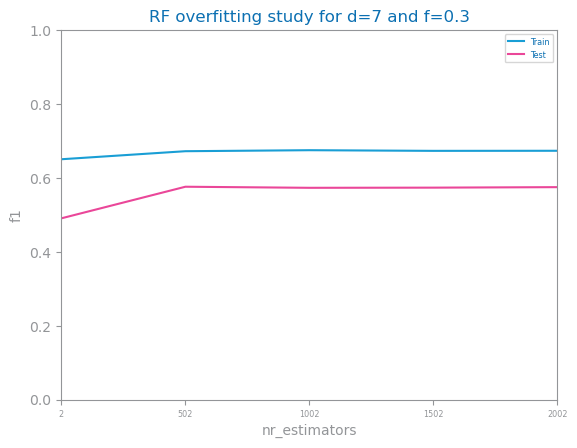

In [9]:
if evaluate==True:
    
    d_max: int = params["params"][0]
    feat: float = params["params"][1]
    nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

    y_tst_values: list[float] = []
    y_trn_values: list[float] = []
    acc_metric: str = "accuracy"

    for n in nr_estimators:
        clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
        clf.fit(trnX, trnY)
        prd_tst_Y: array = clf.predict(tstX)
        prd_trn_Y: array = clf.predict(trnX)
        y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
        y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

    figure()
    plot_multiline_chart(
        nr_estimators,
        {"Train": y_trn_values, "Test": y_tst_values},
        title=f"RF overfitting study for d={d_max} and f={feat}",
        xlabel="nr_estimators",
        ylabel=str(eval_metric),
        percentage=True,
    )
    savefig(f"images/{file_tag}_rf_{eval_metric}_overfitting.png")

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
